# HLS Burn Scars Remote Segmentation Demo
<img src="../assets/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 50px;">
This notebook demonstrates how to load, cache, and visualize remote (HuggingFace-hosted) satellite imagery and segmentation masks using a custom PyTorch Dataset with GDAL.

## Load and Inspect TDML Metadata

We load the TDML file and print basic dataset information: name, number of samples, and number of classes.

In [1]:
import pytdml.io

training_dataset = pytdml.io.read_from_json(
    "croissant_to_ogctdml.json"
)  # read from TDML json file
print("Load training dataset: " + training_dataset.name)
print("Number of training samples: " + str(training_dataset.amount_of_training_data))
print("Number of classes: " + str(training_dataset.number_of_classes))

Load training dataset: HLS_Burn_Scars
Number of training samples: 50
Number of classes: 3


## Define Custom PyTorch Dataset for Remote TIFFs

This cell defines a PyTorch Dataset that:
- Downloads images and masks from HuggingFace URLs (caching them locally)
- Loads multi-band TIFFs using GDAL
- Returns images and masks as PyTorch tensors

We then load the first sample and display the image (first 3 bands as RGB) and the mask (as black and white).

Sample type: <class 'pytdml.type.extended_types.AI_EOTrainingData'>
Sample attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '

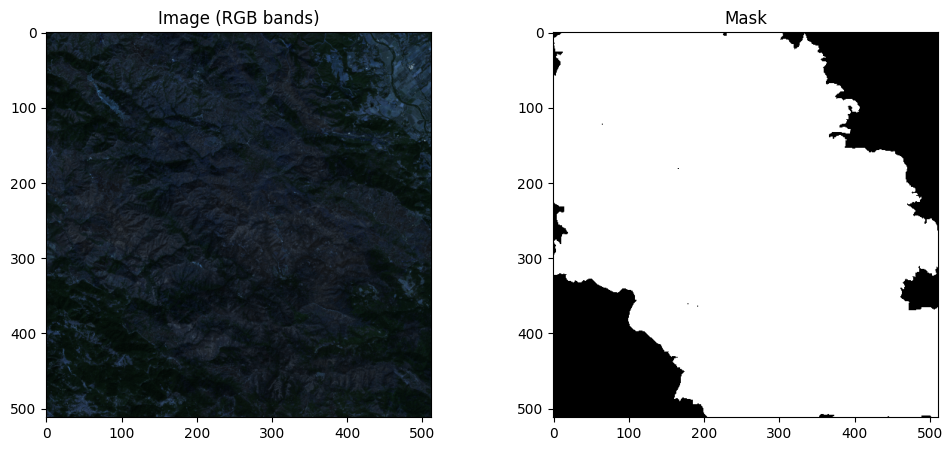

In [2]:
import os
import requests
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import pytdml.io
from osgeo import gdal
import matplotlib.pyplot as plt


class RemoteSegmentationDatasetGDAL(Dataset):
    def __init__(self, tdml_path, transform=None, cache_dir="./cache"):
        self.dataset = pytdml.io.read_from_json(tdml_path)
        self.data = self.dataset.data
        self.transform = transform
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def _download(self, url):
        filename = os.path.join(self.cache_dir, os.path.basename(url))
        if not os.path.exists(filename):
            r = requests.get(url)
            r.raise_for_status()
            with open(filename, "wb") as f:
                f.write(r.content)
        return filename

    def _load_image(self, path):
        ds = gdal.Open(path)
        if ds is None:
            raise RuntimeError(f"GDAL could not open {path}")
        bands = []
        for i in range(1, ds.RasterCount + 1):
            band = ds.GetRasterBand(i).ReadAsArray()
            bands.append(band)
        img = np.stack(bands, axis=-1)  # (H, W, bands)
        return img

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Debug: Print available attributes
        print(f"Sample type: {type(sample)}")
        print(f"Sample attributes: {dir(sample)}")

        # Try different possible attribute names for the image URL
        img_url = None
        for attr_name in ["dataURL", "data_url", "dataUrl", "data"]:
            if hasattr(sample, attr_name):
                attr_value = getattr(sample, attr_name)
                print(f"Found attribute {attr_name}: {attr_value}")
                if isinstance(attr_value, list) and len(attr_value) > 0:
                    img_url = attr_value[0]
                    break

        if img_url is None:
            raise ValueError(f"No image URL found for sample {idx}")

        # Find the AI_PixelLabel object which contains the mask URL
        mask_url = None
        for label in sample.labels:
            print(f"Label type: {type(label)}, attributes: {dir(label)}")
            # Try different possible attribute names for the mask URL
            for attr_name in ["imageURL", "image_url", "imageUrl", "url", "mask_url"]:
                if hasattr(label, attr_name):
                    attr_value = getattr(label, attr_name)
                    print(f"Found label attribute {attr_name}: {attr_value}")
                    if isinstance(attr_value, list) and len(attr_value) > 0:
                        mask_url = attr_value[0]
                        break
            if mask_url:
                break

        if mask_url is None:
            raise ValueError(f"No mask URL found for sample {idx}")

        img_path = self._download(img_url)
        mask_path = self._download(mask_url)

        img = self._load_image(img_path)
        mask = self._load_image(mask_path)

        # For multispectral, ToTensor expects (H, W, C)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()  # (C, H, W)
        mask = torch.from_numpy(mask).long()
        if mask.ndim == 3:
            mask = mask.squeeze()  # Remove channel if present
        return img, mask


# Usage example:
dataset = RemoteSegmentationDatasetGDAL("croissant_to_ogctdml.json", transform=None)

# Loads the first sample.
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Convert to numpy for plotting
img_np = img.permute(1, 2, 0).numpy()  # (H, W, C)
mask_np = mask.numpy()

# Show the first 3 bands as RGB (if available)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
if img_np.shape[2] >= 3:
    plt.imshow(img_np[:, :, :3] / np.max(img_np[:, :, :3]))  # Normalize for display
    plt.title("Image (RGB bands)")
else:
    plt.imshow(img_np[:, :, 0], cmap="grey")
    plt.title("Image (Band 1)")
plt.axis("on")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="grey", vmin=0, vmax=1)
plt.title("Mask")
plt.axis("on")

plt.show()

## Visualize Multiple Samples

This cell loops through the first 5 samples in the dataset, displaying each image and its corresponding mask. This helps verify that the data is being loaded and interpreted correctly.

Sample type: <class 'pytdml.type.extended_types.AI_EOTrainingData'>
Sample attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '

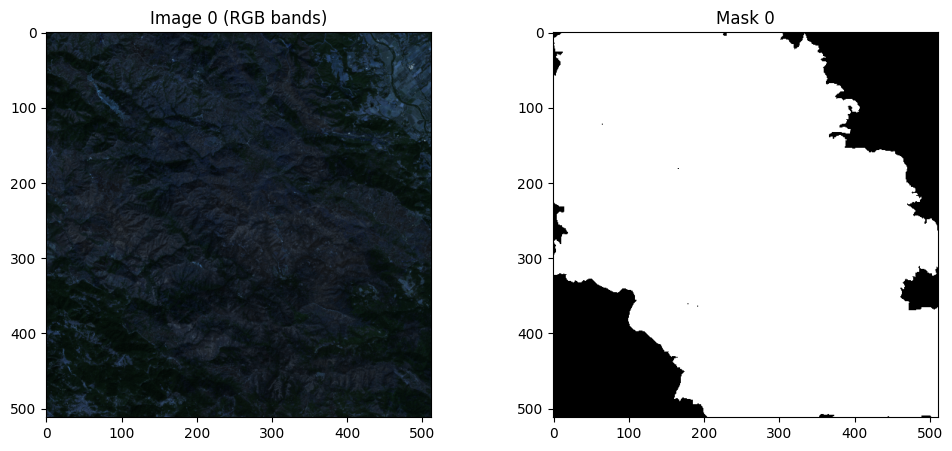

Sample type: <class 'pytdml.type.extended_types.AI_EOTrainingData'>
Sample attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '

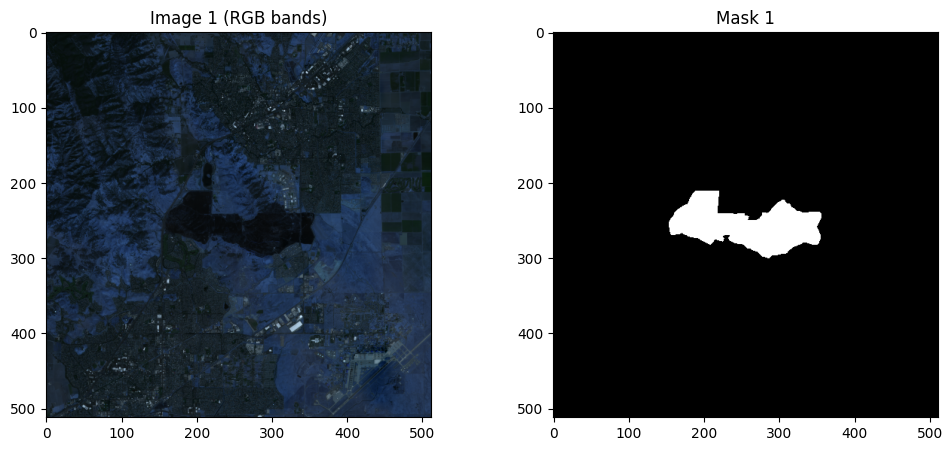

Sample type: <class 'pytdml.type.extended_types.AI_EOTrainingData'>
Sample attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '

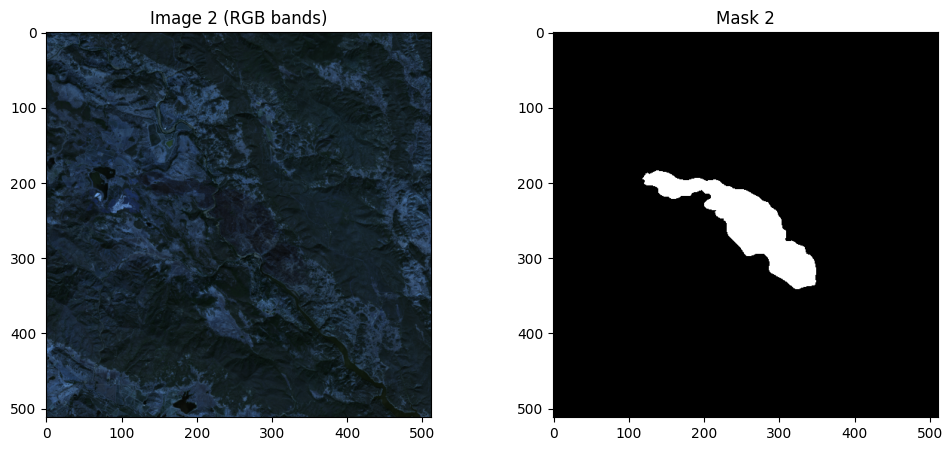

Sample type: <class 'pytdml.type.extended_types.AI_EOTrainingData'>
Sample attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '

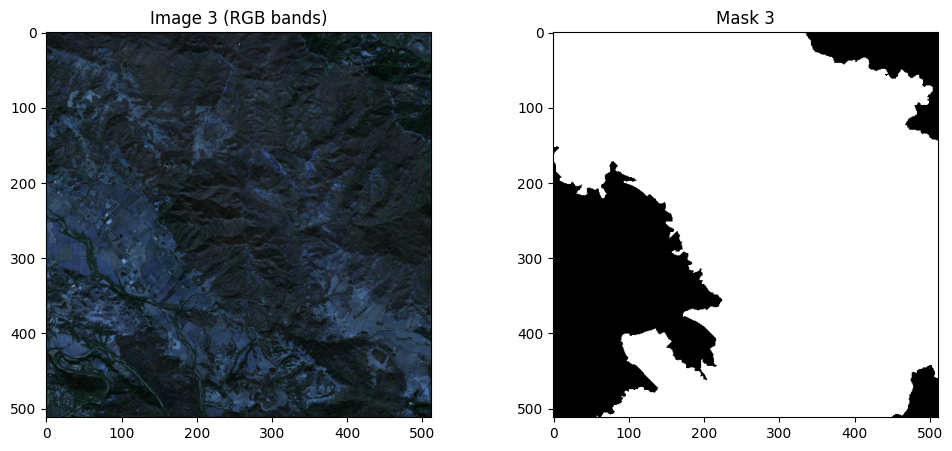

Sample type: <class 'pytdml.type.extended_types.AI_EOTrainingData'>
Sample attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '

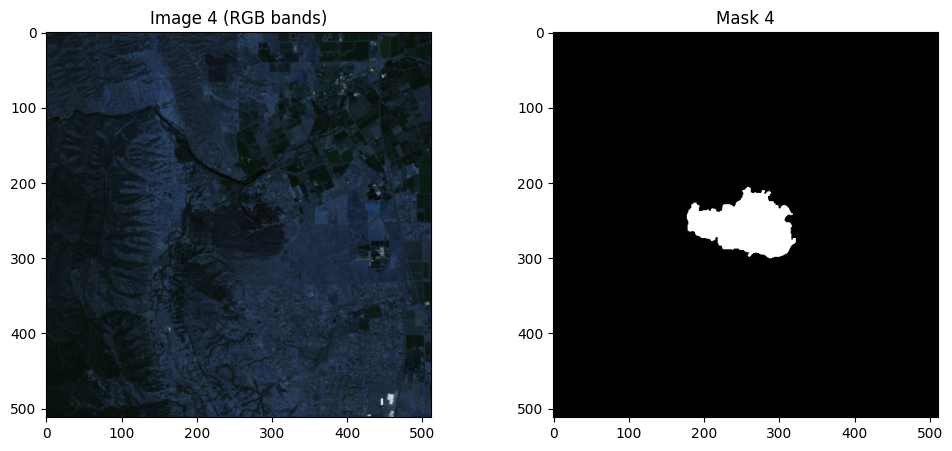

In [3]:
for i in range(5):  # Show first 5 samples
    img, mask = dataset[i]
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    if img_np.shape[2] >= 3:
        plt.imshow(img_np[:, :, :3] / np.max(img_np[:, :, :3]))
        plt.title(f"Image {i} (RGB bands)")
    else:
        plt.imshow(img_np[:, :, 0], cmap="gray")
        plt.title(f"Image {i} (Band 1)")
    plt.axis("on")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="gray", vmin=0, vmax=1)
    plt.title(f"Mask {i}")
    plt.axis("on")
    plt.show()